In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter

In [3]:
BTC_USD = yf.download("BTC-USD", start='2009-01-03', end='2022-04-16', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [4]:
BTC_USD.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


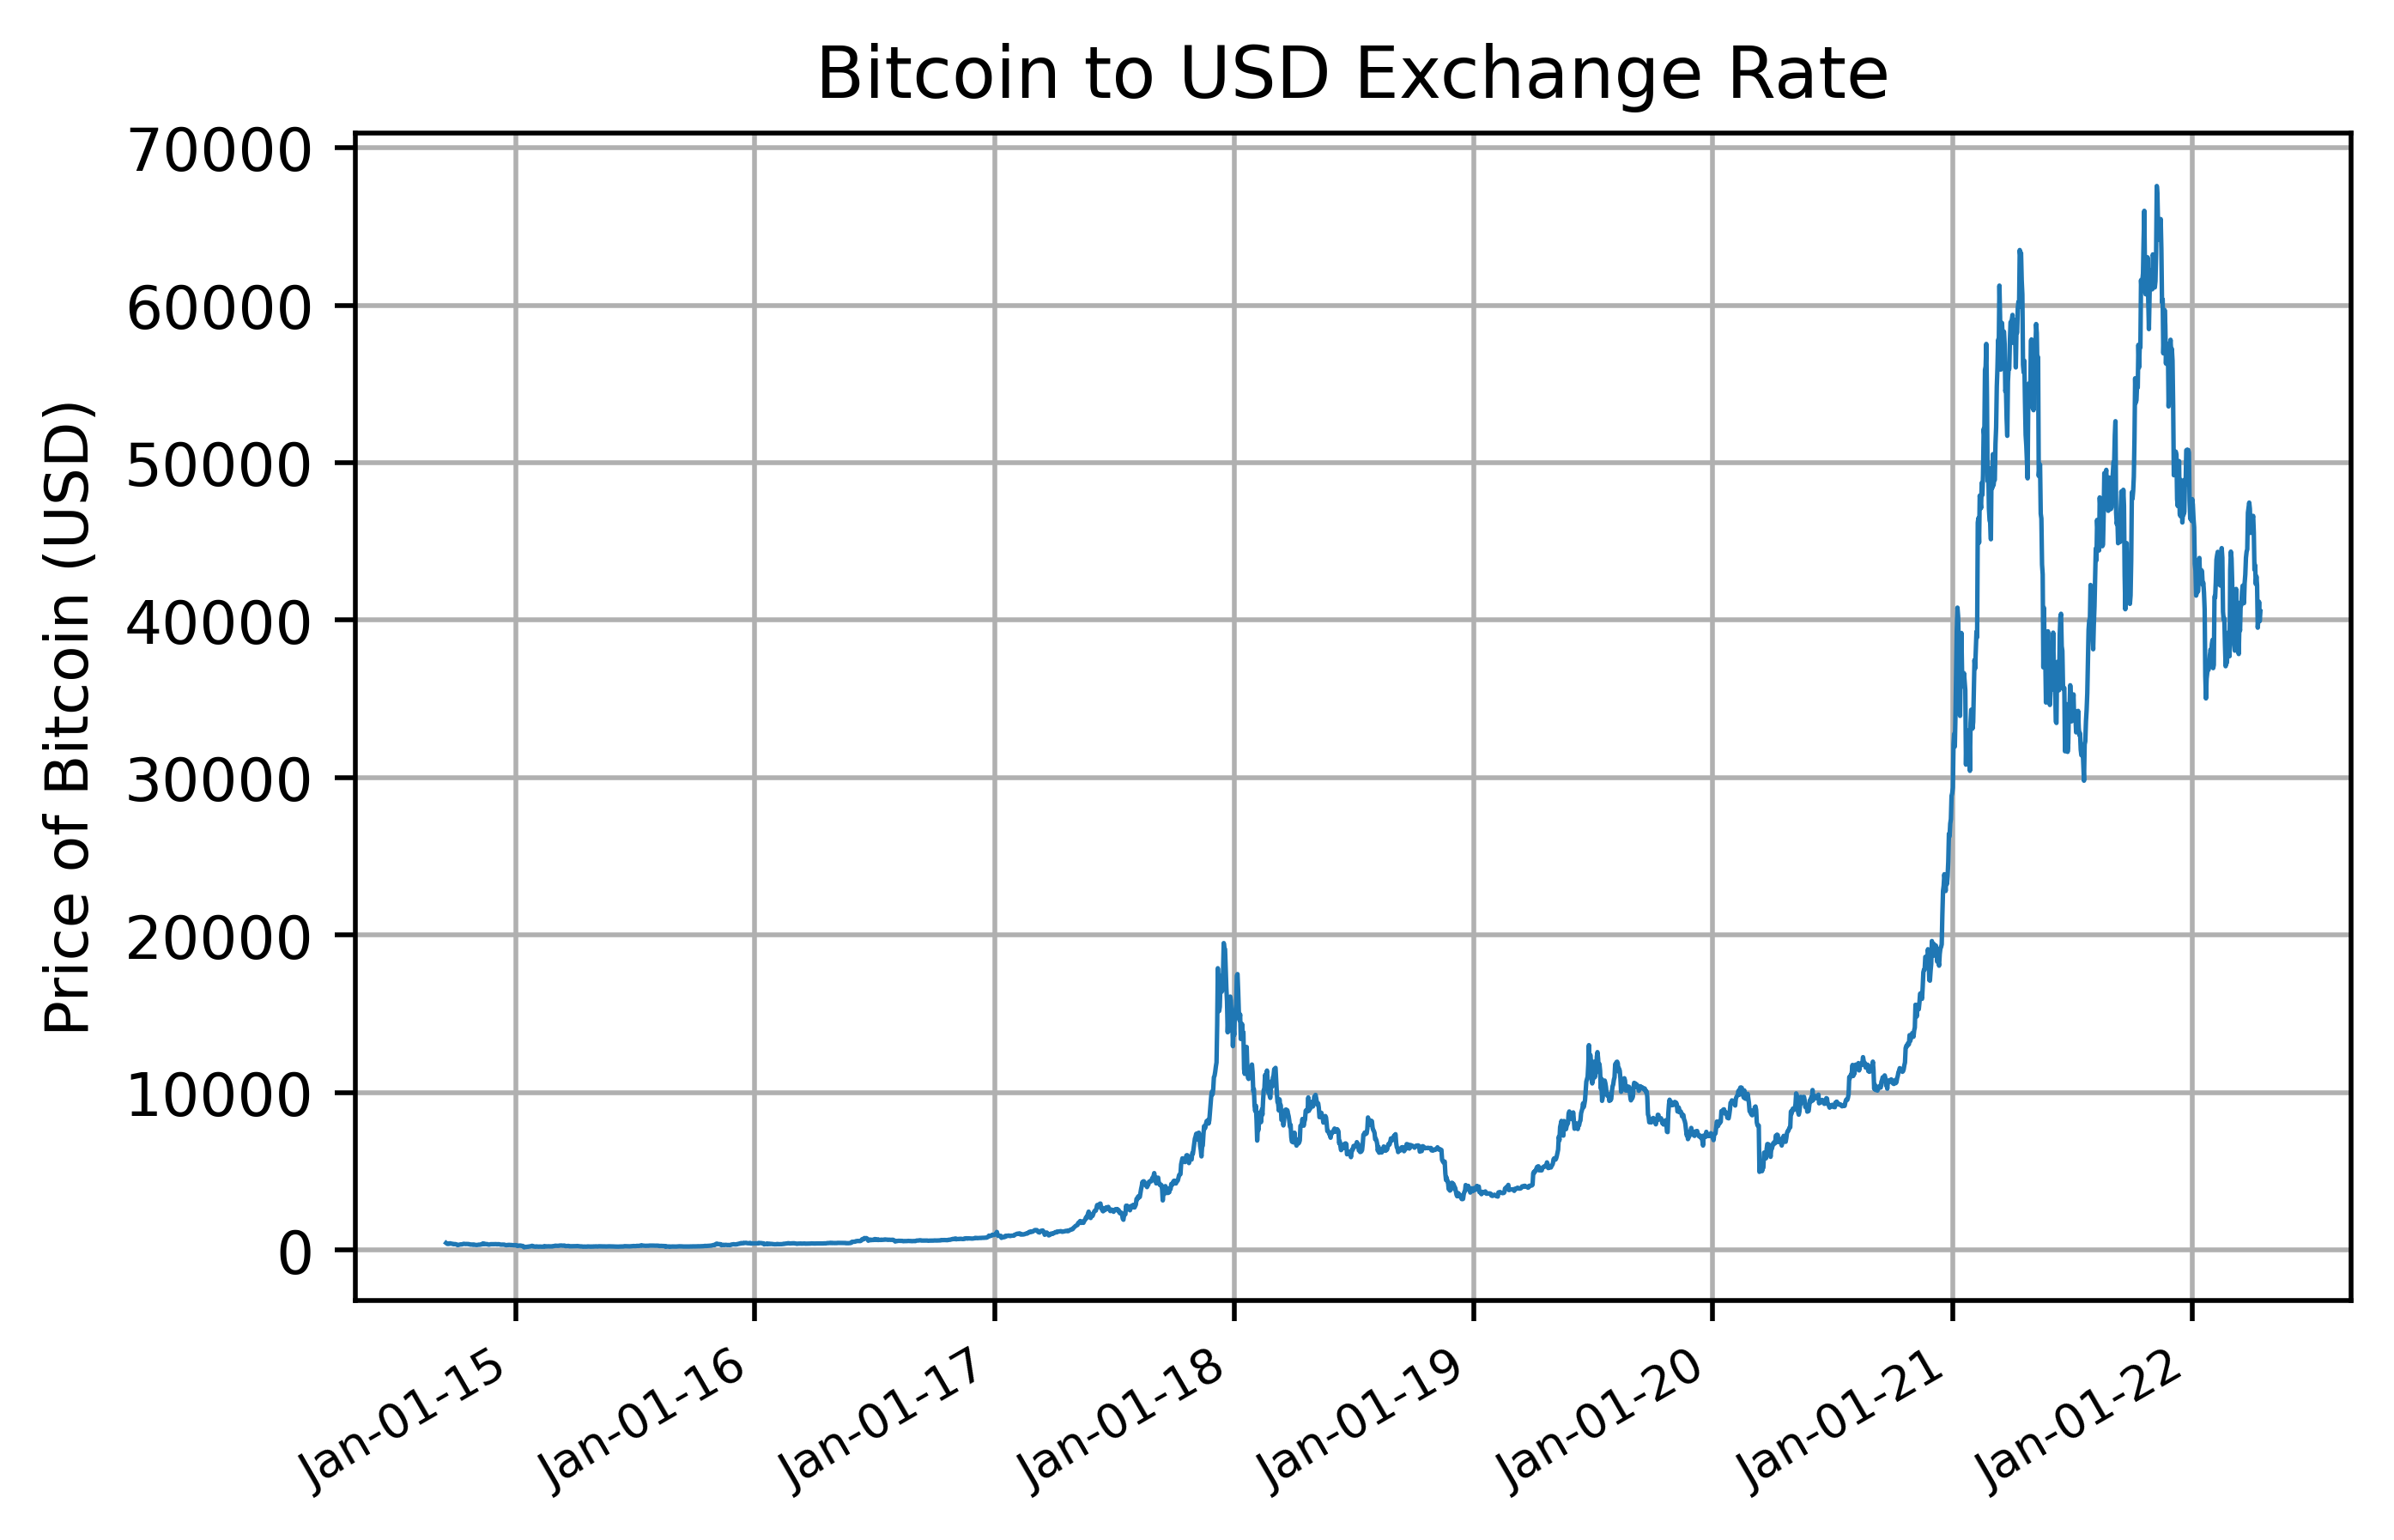

In [5]:
fig, ax = plt.subplots(dpi=500)

# Formatting the date axis
date_format = DateFormatter("%h-%d-%y")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelsize=8)
fig.autofmt_xdate()

# Plotting the closing price against the date (1 day interval)
ax.plot(BTC_USD['Close'], lw=0.75)

# Adding labels and title to the plot
ax.set_ylabel('Price of Bitcoin (USD)')
ax.set_title('Bitcoin to USD Exchange Rate')
ax.grid() # adding a grid

# Displaying the price chart
plt.show()

In [6]:
BTC_USD['SMA_9'] = BTC_USD['Close'].rolling(window=9, min_periods=1).mean()

In [7]:
BTC_USD['SMA_30'] = BTC_USD['Close'].rolling(window = 30, min_periods=1).mean()

In [8]:
BTC_USD.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA_9,SMA_30
Date,,,,,,,,
2022-04-11,42201.039062,42424.589844,39373.058594,39521.902344,39521.902344,33949912166,43571.355035,43387.958464
2022-04-12,39533.714844,40617.585938,39388.328125,40127.183594,40127.183594,30991500854,42868.423611,43463.875781
2022-04-13,40123.570312,41430.054688,39712.746094,41166.730469,41166.730469,27691105228,42262.207465,43513.875000
2022-04-14,41160.218750,41451.480469,39695.746094,39935.515625,39935.515625,24342001973,41637.710069,43533.766016
2022-04-15,39939.402344,40617.722656,39866.832031,40553.464844,40553.464844,21756855753,41342.901910,43514.083854


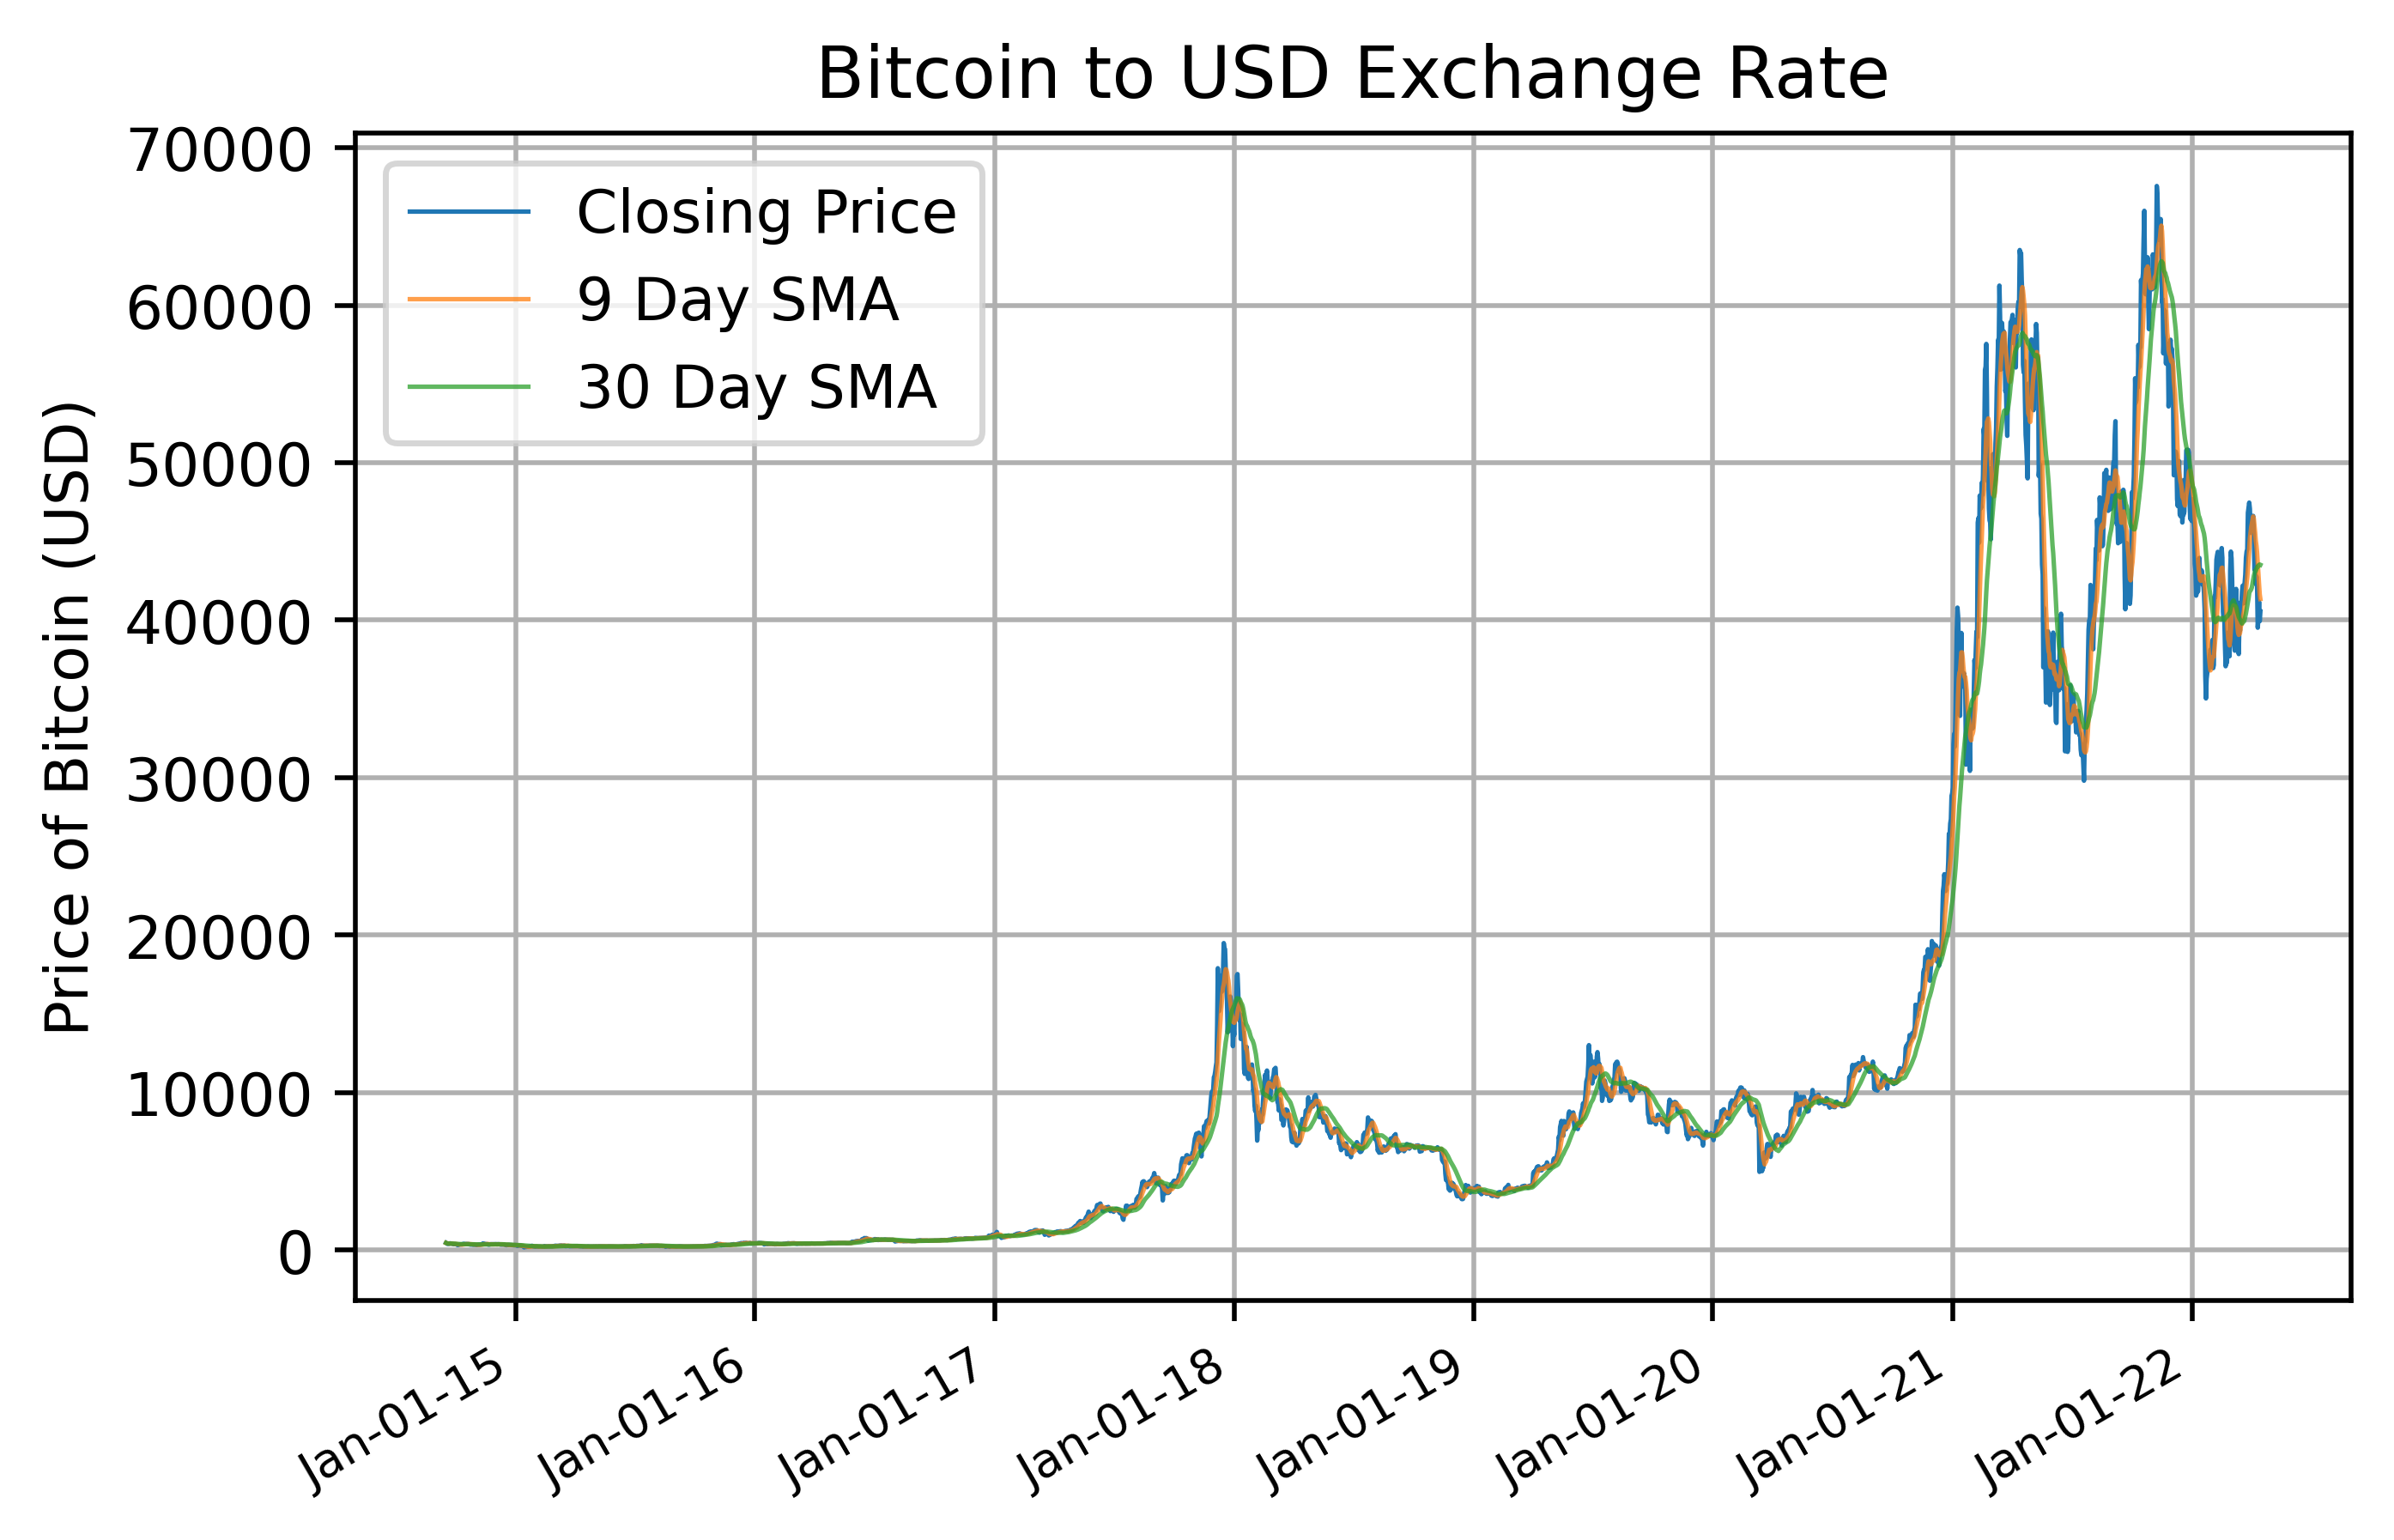

In [9]:
fig, ax = plt.subplots(dpi=500)

# Formatting the date axis
date_format = DateFormatter("%h-%d-%y")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelsize=8)
fig.autofmt_xdate()

# Plotting the closing price against the date (1 day interval)
ax.plot(BTC_USD['Close'], lw=0.75, label='Closing Price') # Added label

ax.plot(BTC_USD['SMA_9'], lw=0.75, alpha=0.75, label='9 Day SMA')
ax.plot(BTC_USD['SMA_30'], lw=0.75, alpha=0.75, label='30 Day SMA')


# Adding labels and title to the plot
ax.set_ylabel('Price of Bitcoin (USD)')
ax.set_title('Bitcoin to USD Exchange Rate')
ax.grid() # adding a grid
ax.legend() # adding a legend

# Displaying the price chart
plt.show()